In [1]:
import itertools
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats.proportion import test_proportions_2indep, confint_proportions_2indep

import matplotlib.pyplot as plt

In [2]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [3]:
def st_pearson_residuals(ct):
    e = stats.chi2_contingency(ct)[3]
    r = e
    n_plus_j = np.sum(ct, axis=0)
    n_i_plus = np.sum(ct, axis=1)
    n = sum(n_plus_j)
    for i in range(len(n_i_plus)):
        for j in range(len(n_plus_j)):
            r[i,j] = (ct.values[i,j] - e[i,j]) / np.sqrt(e[i,j] * (1 - n_i_plus[i] / n) * (1 - n_plus_j[j] / n))
    return pd.DataFrame(data=r, index = ct.index, columns = ct.columns).round(2)
    

In [4]:
def permutation_stat_cat_ind(sample1, sample2):
    ct = pd.crosstab(sample1, sample2)
    return stats.chi2_contingency(ct)[0]

def get_random_permutations(n, max_permutations):
    index = np.array(range(n))
    indices = set([tuple(index)])        
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return list(indices)

def permutation_null_dist_cat_ind(sample1, sample2, max_permutations = None):
    if not len(sample1) == len(sample2):
        raise ValueError("Samples should be paired and have the same size")
        
    n = len(sample1)
    
    if max_permutations:
        indices = get_random_permutations(n, max_permutations)
    else:
        indices = list(itertools.permutations(list(range(n))))
    
    distr = [permutation_stat_cat_ind(sample1, sample2[list(i)]) for i in indices]
    return distr

def permutation_test_cat_ind(sample1, sample2, max_permutations = None, return_distr = False):    
    t_stat = permutation_stat_cat_ind(sample1, sample2)
    
    null_distr = permutation_null_dist_cat_ind(sample1, sample2, max_permutations)
    
    p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [5]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda x: x not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [6]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Credit limit: test whether there are differences between median credit limits of two groups.

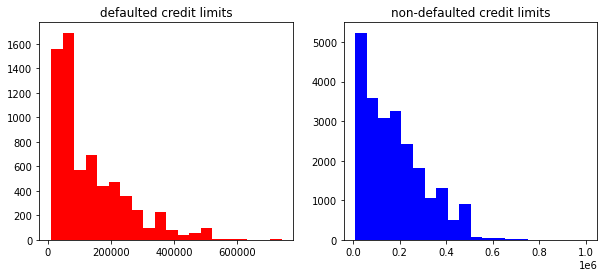

In [7]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(data[data['default'] == 1]['LIMIT_BAL'], color='r', bins=20)
plt.title('defaulted credit limits')

plt.subplot(1, 2, 2)
plt.hist(data[data['default'] == 0]['LIMIT_BAL'], color='b', bins=20)
plt.title('non-defaulted credit limits')
plt.show()

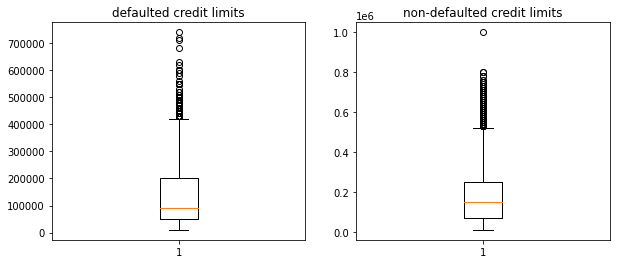

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(data[data['default'] == 1]['LIMIT_BAL'])
plt.title('defaulted credit limits')

plt.subplot(1, 2, 2)
plt.boxplot(data[data['default'] == 0]['LIMIT_BAL'])
plt.title('non-defaulted credit limits')
plt.show()

Here we need to compare averages (medians) of two independent samples. The distribution of variables in both samples look quite skewed so we won't use t-test here. That being said, both samples histograms look quite the similar in shape so we can try to use Mann-Whitney test against the two-sided alternative under the assumption that distibutions are possibly different by a shift. Since we are interested in either the credit limits averages are statistically different or not (rather than the magnitude of the difference), it's fine to use the signed rank test here.

### Mann-Whitney rank test

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta \ne 0$

$X_1$ - defaulted sample; $X_2$ - non-defaulted

In [9]:
print("Mann-Whitney test:", stats.mannwhitneyu(data[data['default'] == 1]['LIMIT_BAL'], data[data['default'] == 0]['LIMIT_BAL']))

Mann-Whitney test: MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)


As we can see, p-value is significantly lower than $\alpha=0.05$. Therefore, we can safely reject $H_0$, which means that the non-defaulted sample is coming from the shifted distribution and hence has a statistically different median. Let's now make point estimate as well as build the confidence interval using bootstrap:

In [10]:
print('Difference in medians: ', data[data['default'] == 1]['LIMIT_BAL'].median() - data[data['default'] == 0]['LIMIT_BAL'].median())

Difference in medians:  -60000.0


In [11]:
np.random.seed(0)
d_median_scores = list(map(np.median, get_bootstrap_samples(data[data['default'] == 1]['LIMIT_BAL'].values, 5000)))
nd_median_scores = list(map(np.median, get_bootstrap_samples(data[data['default'] == 0]['LIMIT_BAL'].values, 5000)))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(d_median_scores, nd_median_scores)))
print("95% confidence interval for the difference between median credit limits:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between median credit limits: [-70000. -60000.]


#### Gender: test whether gender composition of two groups differ

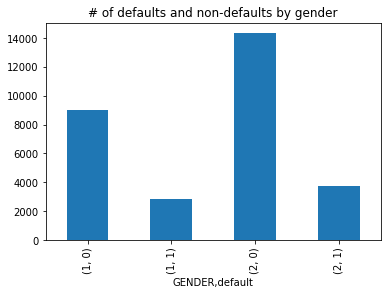

In [12]:
data.groupby(['GENDER', 'default'])['ID'].count().plot(kind='bar')
plt.title('# of defaults and non-defaults by gender')
plt.show()

To test the difference in gender compositions we clearly need a test for the difference in proportions for two independent samples. Since defaults and non-defaults can be encoded as a sequence of Bernoulli experiments we can use Z-test for a difference in proportions as well as Wilson's interval based test as it has good coverage properties.

### Proportions test

$𝐻_0$ : the same proportion of people among men and women defaulted  ( $p_1=p_2$ ).

$𝐻_1$ : the proportions of defaulted people were different among men and women  ( $p_1 \ne p_2$ ).

In [13]:
print("Z test:", test_proportions_2indep(
                    count1=data[(data['GENDER'] == 1) & (data['default'] == 1)].shape[0],
                    nobs1=data[data['GENDER'] == 1].shape[0],
                    count2=data[(data['GENDER'] == 2) & (data['default'] == 1)].shape[0],
                    nobs2=data[data['GENDER'] == 2].shape[0],
                    alternative='two-sided',
                    method='wald', 
                    return_results=False))

Z test: (6.850205366131479, 7.37440456026169e-12)


In [14]:
print("Wilson's interval based test:", 
      test_proportions_2indep(
                    count1=data[(data['GENDER'] == 1) & (data['default'] == 1)].shape[0],
                    nobs1=data[data['GENDER'] == 1].shape[0],
                    count2=data[(data['GENDER'] == 2) & (data['default'] == 1)].shape[0],
                    nobs2=data[data['GENDER'] == 2].shape[0],
                    alternative='two-sided',
                    method='score', 
                    return_results=False))

Wilson's interval based test: (6.921259731350102, 4.4764487319331085e-12)


As we can see in both test p-values are significantly lower than $\alpha=0.05$, therefore we can reject the null hypothesis about the proportions being equal. Let's now make a point estimate and build Wilson confidence interval for the difference:

In [15]:
p1 = data[(data['GENDER'] == 1) & (data['default'] == 1)].shape[0] / data[data['GENDER'] == 1].shape[0]
p2 = data[(data['GENDER'] == 2) & (data['default'] == 1)].shape[0] / data[data['GENDER'] == 2].shape[0]

print('Difference in proportions of defaulted people amoung men and women: ', round(p1 - p2, 4))

Difference in proportions of defaulted people amoung men and women:  0.0339


In [16]:
print("Wilson's confidence interval:", 
      confint_proportions_2indep(
                    count1=data[(data['GENDER'] == 1) & (data['default'] == 1)].shape[0],
                    nobs1=data[data['GENDER'] == 1].shape[0],
                    count2=data[(data['GENDER'] == 2) & (data['default'] == 1)].shape[0],
                    nobs2=data[data['GENDER'] == 2].shape[0],
                    method='score', 
                    compare='diff'))

Wilson's confidence interval: (0.024241567265377125, 0.04362593538693613)


Although proportions are statistically different, the absolute difference is not that big so in practical terms that would not be improtant.

#### Education: test whether education levels differs between two groups. If it does, then how exactly?

In [17]:
ct = pd.crosstab(data['EDUCATION'], data['default'])
ct

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


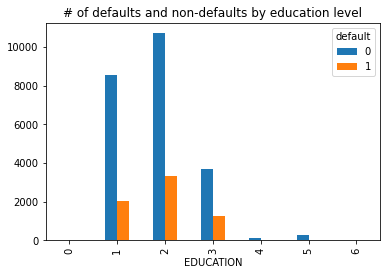

In [18]:
ct.plot(kind='bar')
plt.title('# of defaults and non-defaults by education level')
plt.show()

As we can see the education variable is the categorical one while the default status variable is binary, therefore to test the indepence we need to perform a test on contigency table. To do that we will use Chi-squared test for independence first and see if its' assumptions hold:

### Chi squared test for independence
$H_0$: default status and education level are independent

$H_1$: $H_0$ is false

In [19]:
stats.chi2_contingency(ct)

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

As we can see Chi-squared p-value ($1.23\times10^{-32}$) is significantly lower than $\alpha=0.05$, therefore we can reject the null hypothesis about default status and education level being independent. None of the expected counts are below 5, so Chi-squared test is accurate. Now let's produce some follow-up conclusions using standardized Pearson residuals:

In [20]:
st_pearson_residuals(ct)

default,0,1
EDUCATION,,
0,1.99,-1.99
1,8.89,-8.89
2,-6.32,6.32
3,-5.61,5.61
4,4.40,-4.40
5,6.36,-6.36
6,1.11,-1.11


By looking at values which are >3 or <-3, we can say that people who have masters, elementary or other education were non-defaulting more than it would have been if these two variables were independent, while bachelors and school graduate were non-defaulting less frequently. Still these results are only exploratory because these hypotheses were defined after seeing the data.

#### Marital status: Check how marital status is related to the default indicator: you need to propose a measure by which you can measure the possible relationship of these variables and calculate its value.

In [21]:
ct = pd.crosstab(data['MARITAL'], data['default'])
ct

default,0,1
MARITAL,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


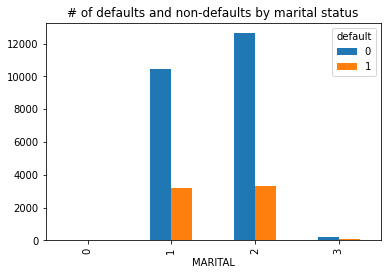

In [22]:
ct.plot(kind='bar')
plt.title('# of defaults and non-defaults by marital status')
plt.show()

As we can see the marital status variable is the categorical one while the default status variable is binary, therefore to test the indepence we need to perform a test on contigency table. To do that we will use Chi-squared test for independence first and see if its' assumptions hold:

### Chi squared test for independence
$H_0$: default status and marital status are independent

$H_1$: $H_0$ is false

In [23]:
stats.chi2_contingency(ct)

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.19448000e+01],
        [1.06376292e+04, 3.02137080e+03],
        [1.24327632e+04, 3.53123680e+03],
        [2.51552400e+02, 7.14476000e+01]]))

As we can see few expected values are actually close to 5.0 so Chi-squared test might be not that accurate here. Let's use the permutation test for independence instead:

In [24]:
np.random.seed(0)
res = permutation_test_cat_ind(data['MARITAL'].values, data['default'].values, 
                              max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 35.662396, p = 0.000100


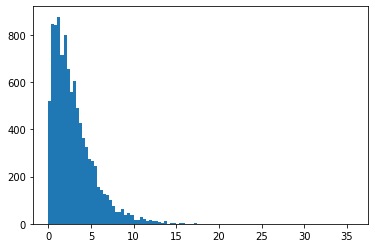

In [25]:
plt.hist(res['null_distr'], bins = 100)
plt.show()

As we can see Permutation p-value ($1.0\times10^{-4}$) is significantly lower than $\alpha=0.05$, therefore we can reject the null hypothesis about marital status and education level being independent. None of the expected counts are below 5, so Chi-squared test is accurate. Now let's produce some follow-up conclusions using standardized Pearson residuals:

In [26]:
st_pearson_residuals(ct)

default,0,1
MARITAL,,
0,2.28,-2.28
1,-5.16,5.16
2,5.30,-5.30
3,-1.69,1.69


By looking at values which are >3 or <-3, it seems that married  clients are defaulting significantly more frequently than it would have been if these two variables were independent, while single clients default less frequently. Again, these results are only exploratory because these hypotheses were defined after seeing the data and would require more unseen data to confirm.

#### Age: test whether there are differences between mean ages of clients in two groups. 

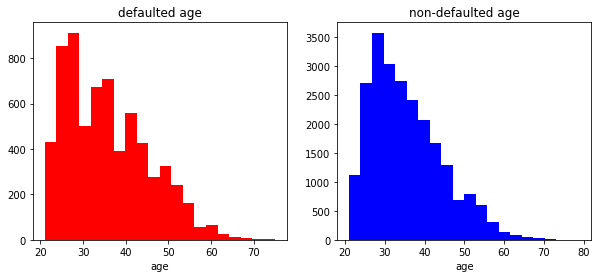

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(data[data['default'] == 1]['AGE'], color='r', bins=20)
plt.xlabel('age')
plt.title('defaulted age')

plt.subplot(1, 2, 2)
plt.hist(data[data['default'] == 0]['AGE'], color='b', bins=20)
plt.xlabel('age')
plt.title('non-defaulted age')
plt.show()

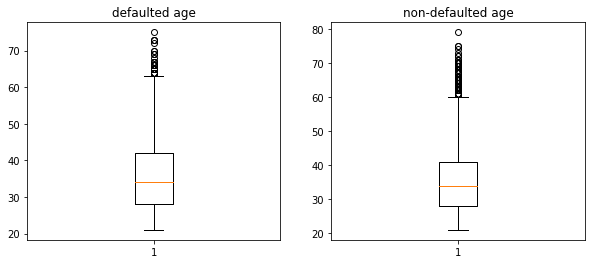

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(data[data['default'] == 1]['AGE'])
plt.title('defaulted age')

plt.subplot(1, 2, 2)
plt.boxplot(data[data['default'] == 0]['AGE'])
plt.title('non-defaulted age')
plt.show()

Here we need to compare averages (means) of two independent samples. The distribution of variables in both samples look a bit skewed but we have enough data for CLT to kick in, so we should be alright using t-test here. Also, both samples distributions seem to be symmetric around the mean as can be seen from the boxplots, therefore we should be safe using Mann-Whitney or Permutation test as well. Before using t-test and corresponding confidence interval, let's look at q-q plots to make sure there are no gross deviations from normality:

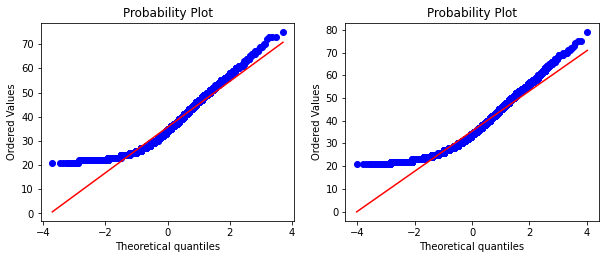

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
stats.probplot(data[data['default'] == 1]['AGE'].values, dist="norm", plot=plt)

plt.subplot(2,2,2)
stats.probplot(data[data['default'] == 0]['AGE'], dist="norm", plot=plt)
plt.show()

As we can see there are quite significant deviations from normal distribution around tails so we should better proceed with Permutation test:

### Permutation test

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta \ne 0$

$X_1$ - defaulted sample; $X_2$ - non-defaulted

In [30]:
np.random.seed(0)
res = permutation_test_2s(data[data['default'] == 1]['AGE'], data[data['default'] == 0]['AGE'], max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 0.308473, p = 0.014800


Null distribution of the permutation test statistic for our data looks quite symmetric, which is good for the power of the test:

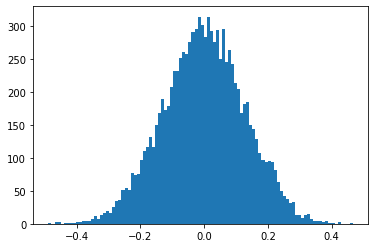

In [31]:
plt.hist(res['null_distr'], bins = 100)
plt.show()

As we can see Permutation test p-value ($0.015$) is less than $\alpha=0.05$, therefore we can reject the hypothesis about the defaulted and non-defaulted samples having the same age distribution. Let's now make point estimate as well as build the confidence interval using bootstrap:

In [32]:
print('Difference in means: ', data[data['default'] == 1]['AGE'].mean() - data[data['default'] == 0]['AGE'].mean())

Difference in means:  0.308472517494188


In [33]:
np.random.seed(0)
d_mean_scores = list(map(np.mean, get_bootstrap_samples(data[data['default'] == 1]['AGE'].values, 5000)))
nd_mean_scores = list(map(np.mean, get_bootstrap_samples(data[data['default'] == 0]['AGE'].values, 5000)))

delta_mean_scores = list(map(lambda x: x[0] - x[1], zip(d_mean_scores, nd_mean_scores)))
print("95% confidence interval for the difference between mean ages:",  
      percentile_interval(delta_mean_scores, 0.05))

95% confidence interval for the difference between mean ages: [0.05528542 0.57533472]


Despite Permutation test saying that we have different age distribtuions for defaulted and non-defaulted clients the actual point-estimate difference is non-significant (i.e. only $\approx0.3$). That being said, if we apply Mann-Whitney test instead we'll get the appropriate results:

### Mann-Whitney test

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta \ne 0$

$X_1$ - defaulted sample; $X_2$ - non-defaulted

In [34]:
print("Mann-Whitney test:", stats.mannwhitneyu(data[data['default'] == 1]['AGE'], data[data['default'] == 0]['AGE']))

Mann-Whitney test: MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)


Mann-Whitney test p-value ($0.19$) is actually higher than $\alpha=0.05$, therefore we can not reject the null hypothesis about defaulting and non-defaulting samples having the same age distibutions.